In [3]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
time_start = time.time()

**Get packet features**

In [4]:
b = BLEPipeline()

In [4]:
b.extract_packet_features(create_master=False)

Old ./BLE_Source deleted
Total number of packets processed:  4285634
Total data processing time:  4650.76798701
Normalized total processing time per 25k packets:  27.1299881594
Total capture file processing time:  951.818542242
Normalized capture file processing time:  5.55237884431


**Produce dataframe**

In [5]:
df = b.make_dataframe()

August2    224739
Energy1     79039
Energy2     71741
Home1       58810
Home2       58614
Push        32761
Kevo        21107
August1     17314
Weather      8643
Room2        8133
Room1        7728
Door1        7374
Door2        4154
Name: Name, dtype: int64


**Prep dataframe**

In [15]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

Resampling: undersampling and oversampling

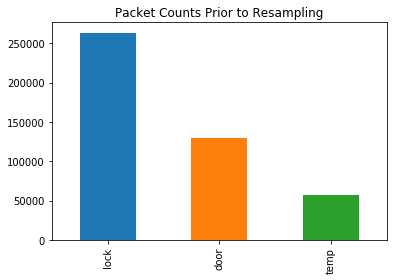

In [16]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#

devtype_df = df["DeviceType"].value_counts()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

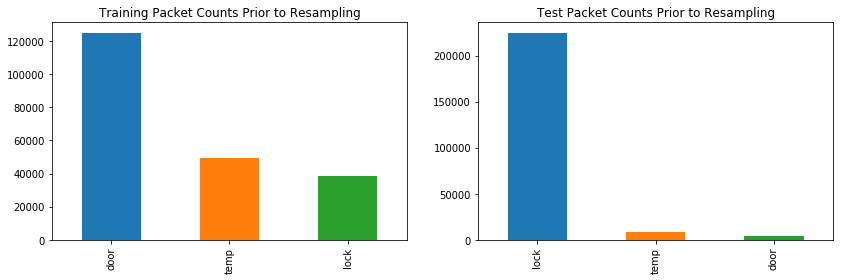

In [17]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
devtype_train = df_train["DeviceType"].value_counts()
plt.subplot(1, 2, 1) #
devtype_train.plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
devtype_test = df_test["DeviceType"].value_counts()
plt.subplot(1, 2, 2)
devtype_test.plot(kind='bar', title="Test Packet Counts Prior to Resampling");


In the training set, the 'door' class has the most packets, with the 'lock' class having the least. 
In the test set, the 'lock' class has the most packets, with the 'door' class having the least. 

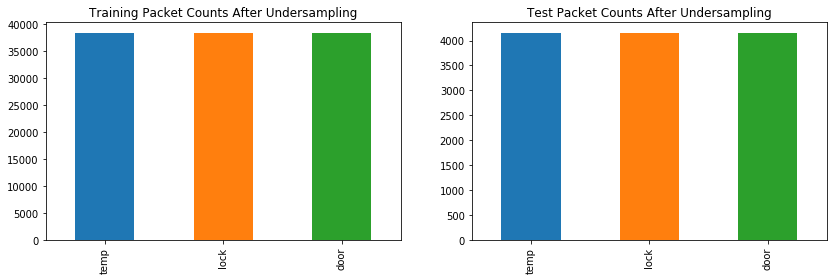

In [18]:
# 1st technique - Random undersampling: 
#     randomly removing packets of the majority classes to match the minority class

kind = "under"
category = "DeviceType"
df_train_undersampled = b.resample(df_train, kind=kind, category=category)
df_test_undersampled = b.resample(df_test, kind=kind, category=category)

# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Undersampling");

plt.subplot(1, 2, 2)
df_test_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Undersampling");

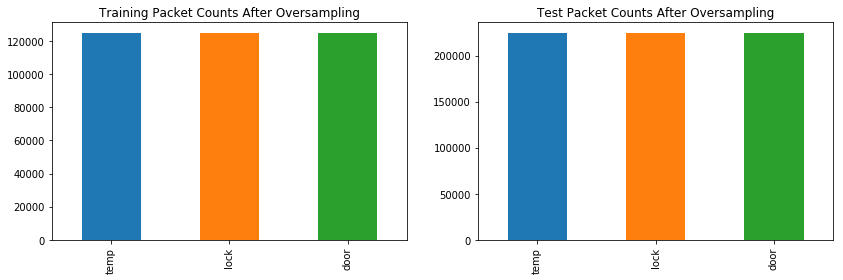

In [19]:
# 2nd technique - Random oversampling: 
#     randomly resampling packets of the minority classes to match the count of the majority class
kind = "over"
category = "DeviceType"
df_train_oversampled = b.resample(df_train, kind=kind, category=category)
df_test_oversampled = b.resample(df_test, kind=kind, category=category)


# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Oversampling");

plt.subplot(1, 2, 2)
df_test_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Oversampling");

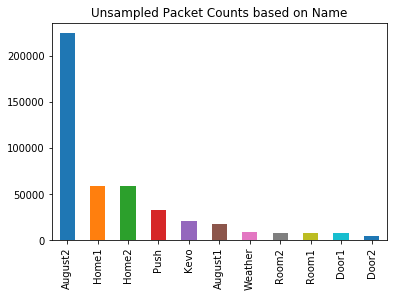

In [20]:
# Another resampling. This time using Name as the category

# First: plot the unsampled df
df["Name"].value_counts().plot(kind='bar', title="Unsampled Packet Counts based on Name");

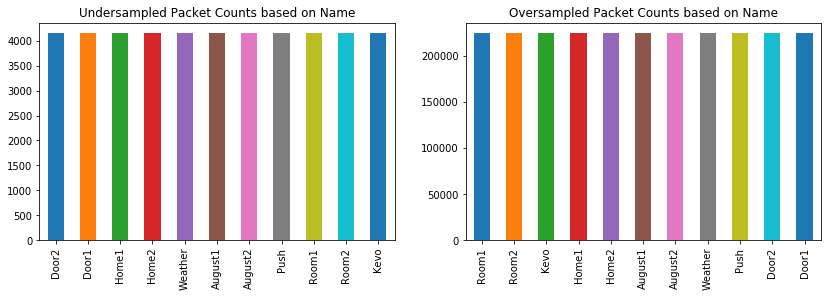

In [21]:
category = "Name"
df_name_undersample = b.resample(df, kind="under", category=category)
df_name_oversample = b.resample(df, kind="over", category=category)

plt.subplots(1, 2, figsize=(14,4))
plt.subplot(1, 2, 1)
df_name_undersample["Name"].value_counts().plot(kind='bar', title="Undersampled Packet Counts based on Name");
plt.subplot(1, 2, 2)
df_name_oversample["Name"].value_counts().plot(kind='bar', title="Oversampled Packet Counts based on Name");

**Create feature list**

In [22]:
# Run One vs All  and One vs One classification strategies
features_list = [
#     'AccessAddr', 'AdvertAddr', 'ScanAddr',
    'BLE_LL_Length', 'TxAddr', 'CompanyID',
    'RFChannel',
    'PacketLength', 'Time', 'Assoc_Packets',
    'ADV_DIRECT_IND', 'ADV_IND', 'ADV_NONCONN_IND', 
    'ADV_SCAN_IND', 'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP']

y_list = ["door", "lock", "temp"]

**Run classification algorithms**

Resampling by DeviceType

In [23]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs one: undersampling by DeviceType\n"
b.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by DeviceType

Device Pair: ('door', 'lock')
Random Forest Score: 0.5565719788155994 Time:  0.599939107895
KNN Score: 0.6337265286470871 Time:  0.99495100975
LDA Score: 0.5 Time:  0.085312128067
Total time (classifiers): 1.68022179604

Device Pair: ('door', 'temp')
Random Forest Score: 0.5113143957631199 Time:  0.521922826767
KNN Score: 0.5054164660568127 Time:  0.792791843414
LDA Score: 0.49987963408762637 Time:  0.0868179798126
Total time (classifiers): 1.40155696869

Device Pair: ('lock', 'temp')
Random Forest Score: 0.9222436206066442 Time:  0.533895015717
KNN Score: 0.9845931632161772 Time:  0.705276966095
LDA Score: 0.9997592681752527 Time:  0.0825669765472
Total time (classifiers): 1.32176804543

Total time (one vs one_classify): 4.6169500351



In [24]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs all: undersampling by DeviceType\n"
b.one_vs_all_classify(df_undersample, features_list, y_list)

One vs all: undersampling by DeviceType

Device Type: door
Random Forest Score: 0.6804686246188413 Time:  0.60648393631
KNN Score: 0.6681110576151501 Time:  1.1476418972
LDA Score: 0.3333333333333333 Time:  0.100116968155
Total time (classifiers): 1.85426592827

Device Type: lock
Random Forest Score: 0.6860054565880276 Time:  0.666511774063
KNN Score: 0.9907719467180228 Time:  1.1608171463
LDA Score: 0.6666666666666666 Time:  0.126258134842
Total time (classifiers): 1.95361113548

Device Type: temp
Random Forest Score: 0.6697159364467983 Time:  0.661710977554
KNN Score: 0.6679505697319852 Time:  1.06900000572
LDA Score: 0.6665061787835018 Time:  0.0946288108826
Total time (classifiers): 1.82536196709

Total time (one vs all_classify): 5.70923018456



In [25]:
df_oversample = pd.concat([df_train_oversampled, df_test_oversampled], axis=0)
print "One vs one: oversampling by DeviceType\n"
b.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by DeviceType

Device Pair: ('door', 'lock')
Random Forest Score: 0.6451439225056621 Time:  1.39906287193
KNN Score: 0.8795224682854333 Time:  28.3722889423
LDA Score: 0.5000022248029937 Time:  0.280744075775
Total time (classifiers): 30.0521118641

Device Pair: ('door', 'temp')
Random Forest Score: 0.509217358802878 Time:  1.88798594475
KNN Score: 0.5091995603789284 Time:  16.7169120312
LDA Score: 0.499948829531145 Time:  0.422163009644
Total time (classifiers): 19.02709198

Device Pair: ('lock', 'temp')
Random Forest Score: 0.998155638318227 Time:  1.22342991829
KNN Score: 0.996740663614237 Time:  24.4311230183
LDA Score: 0.9998531630024161 Time:  0.296211957932
Total time (classifiers): 25.9507820606

Total time (one vs one_classify): 76.5340459347



In [26]:
print "One vs all: oversampling by DeviceType\n"
b.one_vs_all_classify(df_oversample, features_list, y_list)

One vs all: oversampling by DeviceType

Device Type: door
Random Forest Score: 0.44291081358079076 Time:  2.70959496498
KNN Score: 0.6723235990786349 Time:  28.9651451111
LDA Score: 0.3333852454031862 Time:  0.541402101517
Total time (classifiers): 32.2161641121

Device Type: lock
Random Forest Score: 0.6666800154846289 Time:  1.92379593849
KNN Score: 0.9979843284877125 Time:  27.9603970051
LDA Score: 0.6664946152351543 Time:  0.521445035934
Total time (classifiers): 30.4056558609

Device Type: temp
Random Forest Score: 0.6740633950197044 Time:  2.36854100227
KNN Score: 0.6728456861811554 Time:  30.559073925
LDA Score: 0.6665717417389356 Time:  0.560254096985
Total time (classifiers): 33.4878861904

Total time (one vs all_classify): 96.3749170303



Resampling by Name

In [27]:
df_undersample = df_name_undersample

time_start = time.time()

print "One vs one: undersampling by Name\n"
b.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by Name

Device Pair: ('door', 'lock')
Random Forest Score: 0.503129513721714 Time:  0.421494007111
KNN Score: 0.9200770341839191 Time:  0.372838973999
LDA Score: 0.5 Time:  0.0146901607513
Total time (classifiers): 0.809038877487

Device Pair: ('door', 'temp')
Random Forest Score: 0.5012036591237362 Time:  0.425405025482
KNN Score: 0.5115551275878671 Time:  0.463515996933
LDA Score: 0.49987963408762637 Time:  0.0288150310516
Total time (classifiers): 0.91775894165

Device Pair: ('lock', 'temp')
Random Forest Score: 0.999037072701011 Time:  0.430546998978
KNN Score: 0.9880837746750121 Time:  0.333346128464
LDA Score: 0.9996389022628791 Time:  0.0161168575287
Total time (classifiers): 0.780030012131

Total time (one vs one_classify): 2.61608600616



In [28]:
print "One vs All: undersampling by Name\n"
b.one_vs_all_classify(df_undersample, features_list, y_list)

One vs All: undersampling by Name

Device Type: door
Random Forest Score: 0.36679505697319853 Time:  0.385605096817
KNN Score: 0.6733269138180067 Time:  0.416173934937
LDA Score: 0.3332530893917509 Time:  0.0232028961182
Total time (classifiers): 0.825001001358

Device Type: lock
Random Forest Score: 0.6666666666666666 Time:  0.368851900101
KNN Score: 0.9975926817525277 Time:  0.440145969391
LDA Score: 0.6666666666666666 Time:  0.0238411426544
Total time (classifiers): 0.832854986191

Device Type: temp
Random Forest Score: 0.6730059380516771 Time:  0.390007019043
KNN Score: 0.6732466698764243 Time:  0.466377019882
LDA Score: 0.6664259348419195 Time:  0.0246789455414
Total time (classifiers): 0.881087064743

Total time (one vs all_classify): 2.56342196465



In [29]:
df_oversample = df_name_oversample

print "One vs one: oversampling by Name\n"
b.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by Name

Device Pair: ('door', 'lock')
Random Forest Score: 0.6402426815105522 Time:  3.62495207787
KNN Score: 0.9927248942106176 Time:  990.661736965
LDA Score: 0.5000066744089811 Time:  1.46108698845
Total time (classifiers): 995.747796059

Device Pair: ('door', 'temp')
Random Forest Score: 0.5189108254464068 Time:  7.01753401756
KNN Score: 0.5143121576584393 Time:  1405.41839719
LDA Score: 0.4999443799251576 Time:  2.01610088348
Total time (classifiers): 1414.45204997

Device Pair: ('lock', 'temp')
Random Forest Score: 0.7921589043290217 Time:  3.44792222977
KNN Score: 0.9987496607175435 Time:  994.720232964
LDA Score: 0.9998642870173846 Time:  1.42698907852
Total time (classifiers): 999.595163822

Total time (one vs one_classify): 3413.36533594



In [30]:
print "One vs all: oversampling by Name\n"
b.one_vs_all_classify(df_oversample, features_list, y_list)

One vs all: oversampling by Name

Device Type: door
Random Forest Score: 0.36238629402699724 Time:  8.98526501656
KNN Score: 0.6755807106614042 Time:  2326.5635829
LDA Score: 0.3336907850143203 Time:  2.69388699532
Total time (classifiers): 2338.24275208

Device Type: lock
Random Forest Score: 0.7157740015454965 Time:  5.82645010948
KNN Score: 0.9989988386528373 Time:  2523.22933388
LDA Score: 0.6666711162726541 Time:  2.91377687454
Total time (classifiers): 2531.96957803

Device Type: temp
Random Forest Score: 0.6744386451246409 Time:  8.76234006882
KNN Score: 0.6762733659934412 Time:  2363.50247002
LDA Score: 0.6665761913449231 Time:  2.45405197144
Total time (classifiers): 2374.71887994

Total time (one vs all_classify): 7245.54366302



**Time Metrics**

In [31]:
print "Total time:", time.time() - time_start

Total time: 10664.2673399
